# Results leave-one-out tests of FIX classification 
This notebook plots the results of the FIX classification performance in labelling noise and signal in the single-subject ICAs of the MDTB resting-state data (calculated using leave-one-out evaluation on the hand-labelled MDTB resting state components).
The results from the evaluation helps choosing a threshold for FIX-based cleaning of all MDTB resting-state scans.
N.B. Because we classified smoothed and unsmoothed resting-state data, the results are split by the presence of smoothing.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import Functional_Fusion.util as ut
import preprocessing.paths as paths
import preprocessing.rest_mdtb as rs_md
import numpy as np

## Get paths and data

In [3]:
# set paths
base_dir = paths.set_base_dir()
atlas_dir = paths.set_atlas_dir(base_dir)
figure_dir = paths.set_figure_dir()
export_dir = paths.set_export_dir(base_dir)

ica_dir = f'{base_dir}/../Cerebellum/super_cerebellum/resting_state/'

In [6]:
# Import data table from leave-one-out evaluation file (everything before 'set of thresholds')
D_list = []
for results in ['mdtb_rest_LOO_results', 'hcp3t_results']:
    results_file = f'{ica_dir}/{results}'
    thresholds_line = 'set of thresholds is:'
    with open(results_file, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if thresholds_line in line:
                break

    # load data
    D = pd.read_csv(results_file, nrows=i-3, delim_whitespace=True, header=None)

    # Add the threshold information
    with open(results_file, 'r') as file:
        # Read all lines
        lines = file.readlines()
        # Get line with thresholds
        thresholds = lines[i] 

    thresholds = thresholds.strip(thresholds_line).split()
    D.columns = [f'{criterion}_{thresh}' for thresh in thresholds for criterion in ['TPR', 'TNR']]

    # Add subject, run and preprocessing information
    folder_list = rs_md.get_ica_folders()
    folder_list = [folder.split('imaging_data/')[1] for folder in folder_list]

    D['smoothed'] = [True if 'smoothed' in folder else False for folder in folder_list]
    D['subject'] = [folder.split('/')[0] for folder in folder_list]
    D['run'] = [folder.split('/')[1][:5] for folder in folder_list]
    D['training'] = results.split('_')[0]
    D_list.append(D)

# Concatenate the dataframes
D = pd.concat(D_list)


## Melt data

In [8]:
# Melt dataframe
d = pd.melt(D, var_name='variable', value_name='value', id_vars=['subject', 'run', 'smoothed', 'training'])
# Extract the threshold column
d['threshold'] = d['variable'].str.extract('(\d+)').astype(int)
# Extract the measurement type column
d['measurement'] = d['variable'].str.split('_').str[0]
# Drop the original variable column
d = d.drop(columns='variable')
d.head()

,subject,run,smoothed,training,value,threshold,measurement
0,s02,run01,True,mdtb,100.0,1,TPR
1,s02,run02,True,mdtb,100.0,1,TPR
2,s03,run01,True,mdtb,100.0,1,TPR
3,s06,run02,True,mdtb,100.0,1,TPR
4,s07,run02,True,mdtb,100.0,1,TPR


## Calculate TPR_TNR Index

In [9]:
# Calculate TPR_TNR index
d = d.sort_values(by=['training', 'subject', 'smoothed', 'run', 'threshold'])
tpr = d.query('measurement == "TPR"')['value'].values
tnr = d.query('measurement == "TNR"')['value'].values   
tpr_tnr = d.query('measurement == "TNR"').copy()
tpr_tnr['value'] = (3*tpr+tnr)/4
tpr_tnr['measurement'] = 'TPR_TNR'

# add to dataframe
d = pd.concat([d, tpr_tnr], axis=0)
d = d.sort_values(by=['subject', 'smoothed', 'run', 'threshold'])

d.head(10)


,subject,run,smoothed,training,value,threshold,measurement
24,s02,run01,True,hcp3t,100.0,1,TPR
72,s02,run01,True,hcp3t,0.0,1,TNR
0,s02,run01,True,mdtb,100.0,1,TPR
48,s02,run01,True,mdtb,67.2,1,TNR
72,s02,run01,True,hcp3t,75.0,1,TPR_TNR
48,s02,run01,True,mdtb,91.8,1,TPR_TNR
120,s02,run01,True,hcp3t,100.0,2,TPR
168,s02,run01,True,hcp3t,1.7,2,TNR
96,s02,run01,True,mdtb,100.0,2,TPR
144,s02,run01,True,mdtb,70.7,2,TNR


# Plot results

## Plot mean performance
Training was either performed with hand-labelled MDTB dataset or with FIX-provided training dataset (HCP 3T data or 'Standard' neuroimaging data - see parameters [here](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FIX/UserGuide#Trained-weights_files)).
For evaluation, FIX was leave-one-out tested on hand-labelled MDTB dataset which was either smoothed and highpass-filtered or not (smoothed TRUE or FALSE).

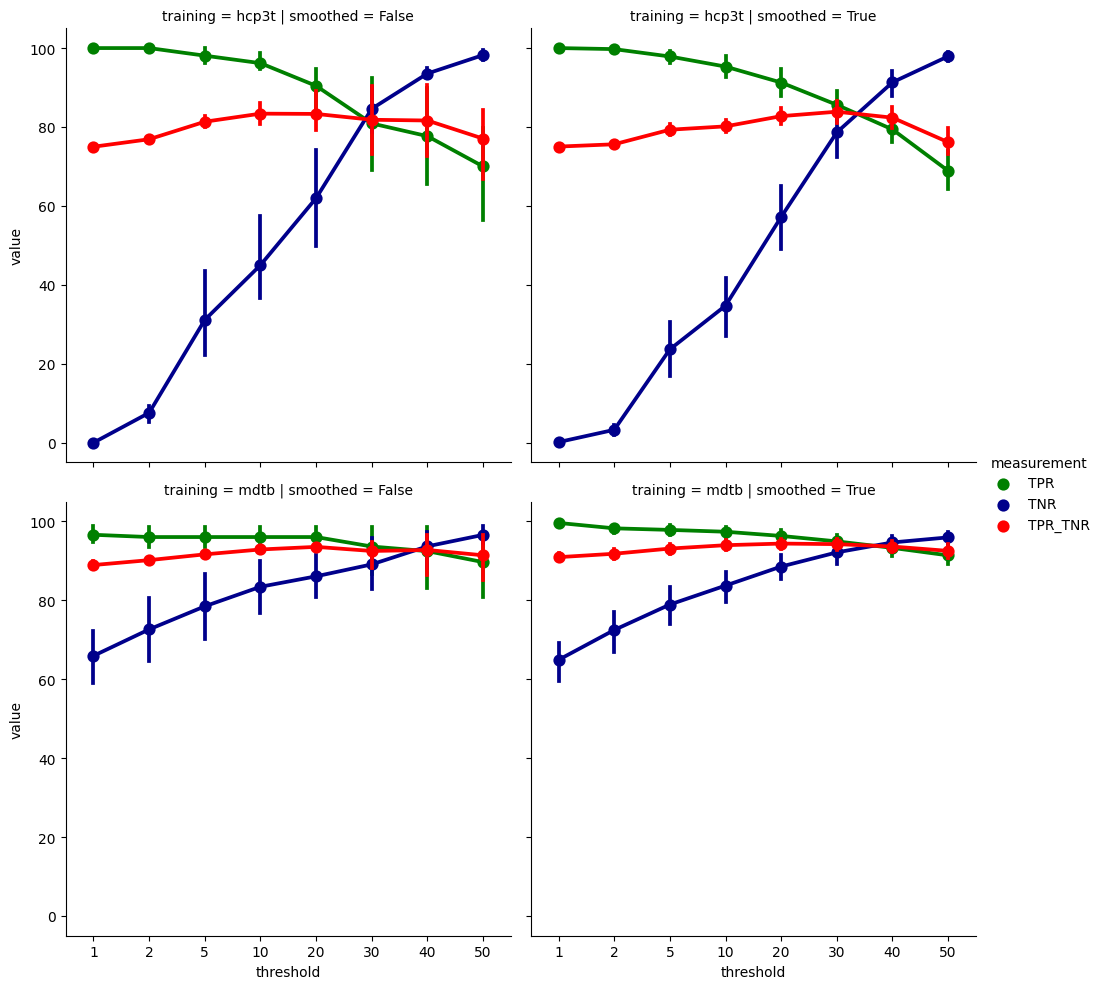

In [20]:
# Plot with hue='measurement', style='smoothed' and y='value'  
sb.catplot(data=d, x='threshold', y='value', hue='measurement', row='smoothed', col='training', kind='point', palette=['green', 'darkblue', 'red'])

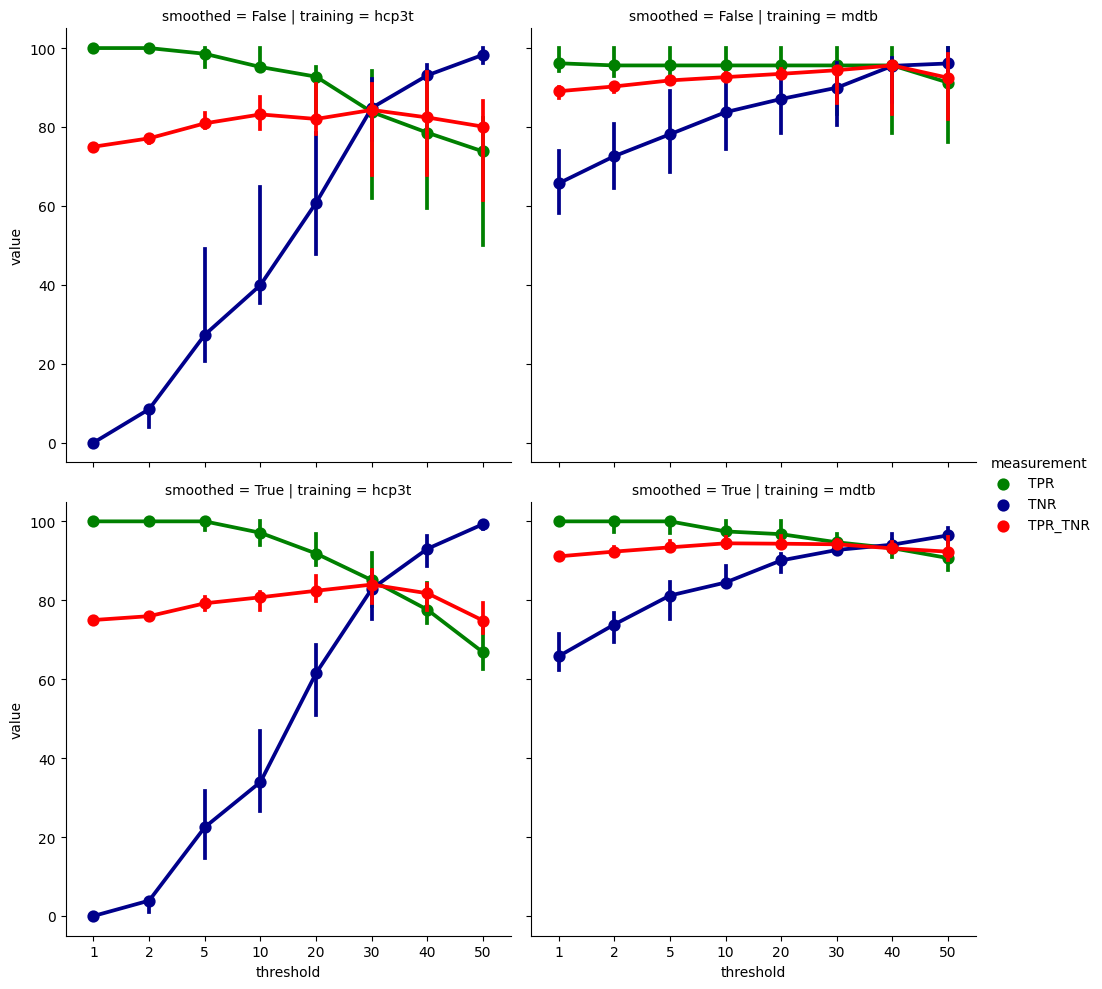

In [19]:
# Plot with hue='measurement', style='smoothed' and y='value'  
sb.catplot(data=d, x='threshold', y='value', hue='measurement', row='smoothed', col='training', kind='point', palette=['green', 'darkblue', 'red'], estimator=np.median)

<Axes: xlabel='threshold', ylabel='value'>

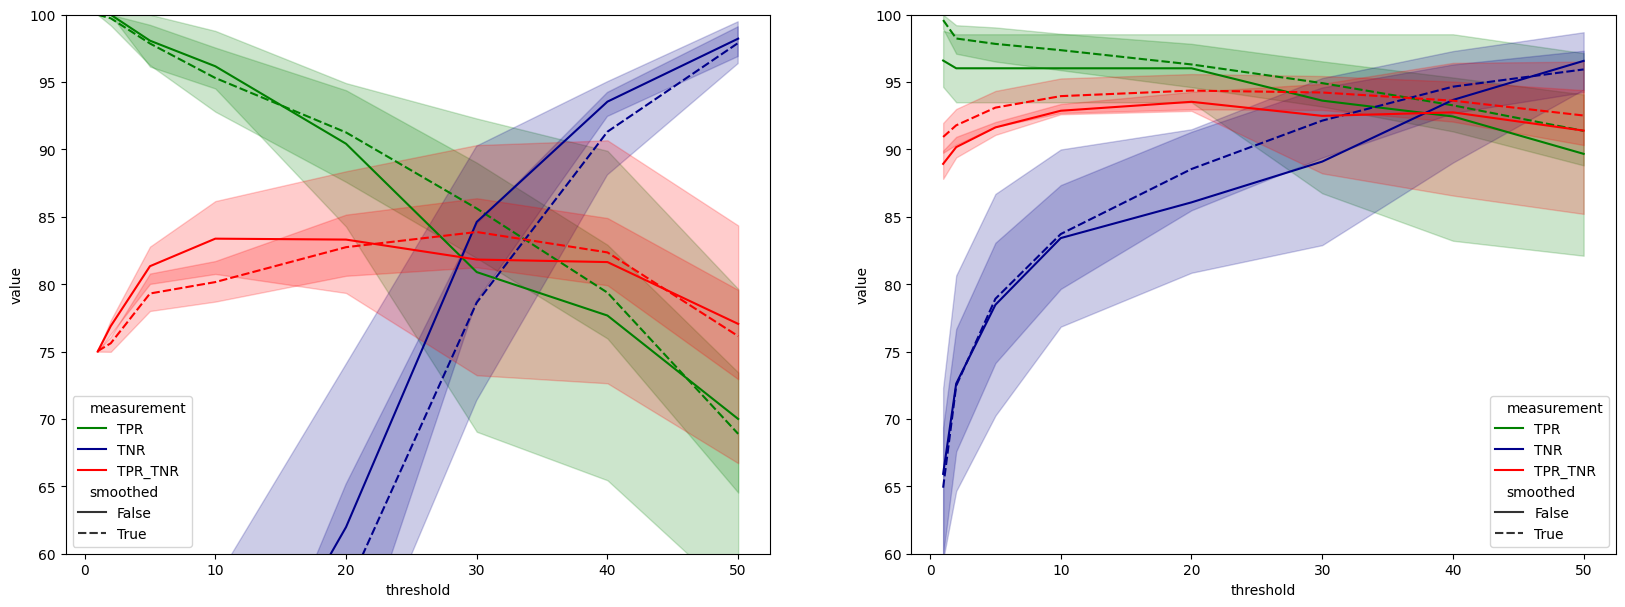

In [39]:
# Plot in subplots and make yaxis the same
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ylim = (60, 100)
ax[0].set_ylim(ylim)
sb.lineplot(data=d.query('training == "hcp3t"'), x='threshold', y='value', hue='measurement', style='smoothed', palette=['green', 'darkblue', 'red'], ax=ax[0])
ax[1].set_ylim(ylim)
sb.lineplot(data=d.query('training == "mdtb"'), x='threshold', y='value', hue='measurement', style='smoothed', palette=['green', 'darkblue', 'red'], ax=ax[1])

<Axes: xlabel='threshold', ylabel='value'>

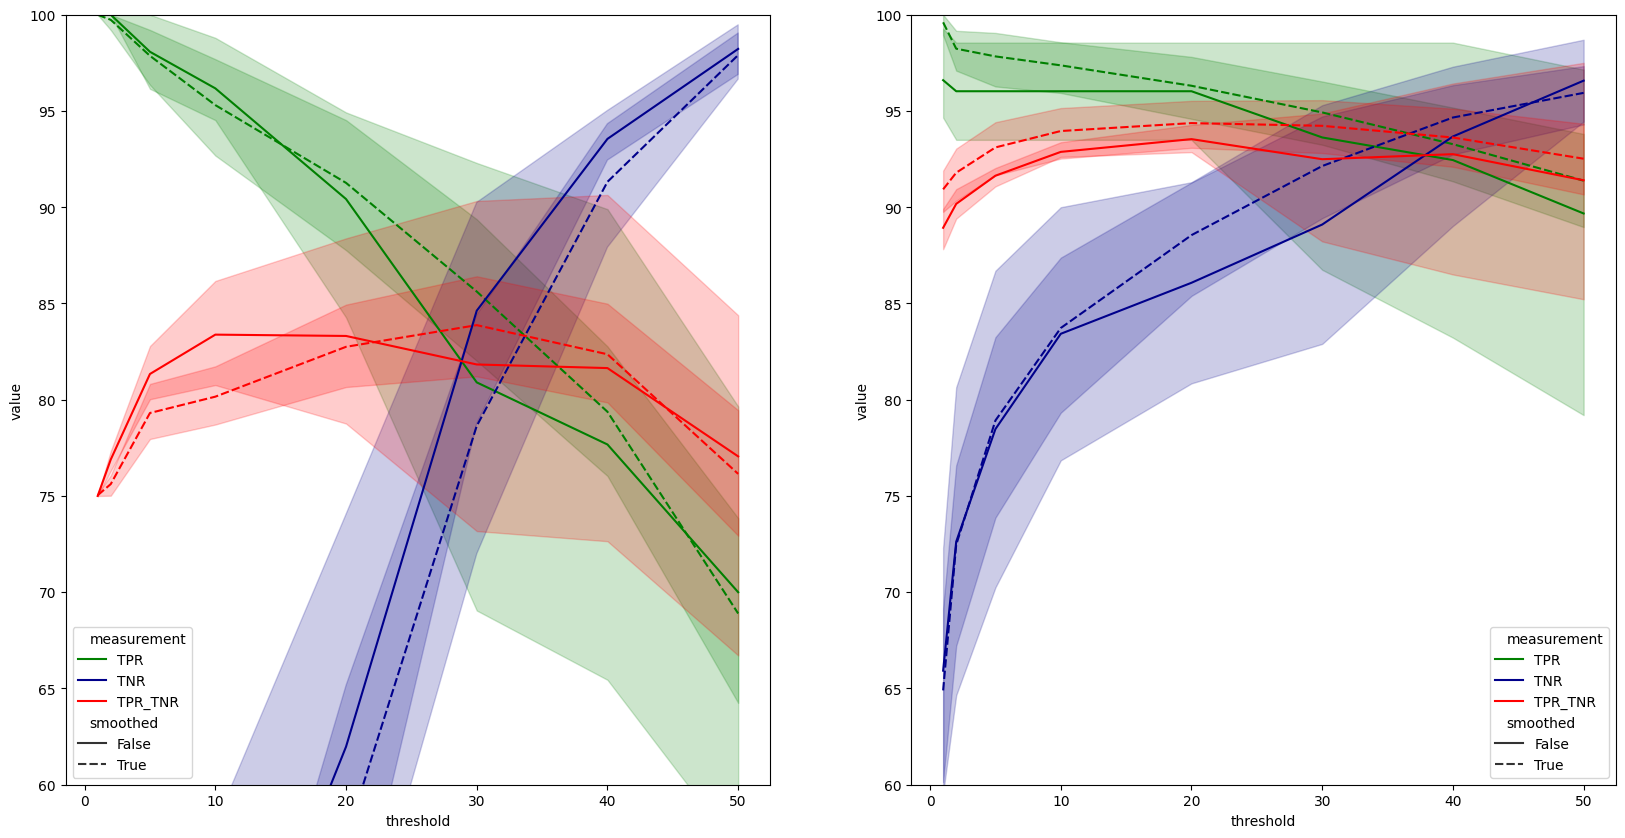

In [26]:
# Plot in subplots and make yaxis the same
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ylim = (60, 100)
ax[0].set_ylim(ylim)
sb.lineplot(data=d.query('training == "hcp3t"'), x='threshold', y='value', hue='measurement', style='smoothed', palette=['green', 'darkblue', 'red'], ax=ax[0])
ax[1].set_ylim(ylim)
sb.lineplot(data=d.query('training == "mdtb"'), x='threshold', y='value', hue='measurement', style='smoothed', palette=['green', 'darkblue', 'red'], ax=ax[1])